# Advanced Generative Chatbot Using BERT model
## AAI-520 Team 3 Final Project

Team 3 Members:  Tyler Foreman, Ahmed Ahmed, Tursun Alkam

Date:  October 23, 2023

GitHub Repository: https://github.com/t4ai/aai520-team3-final

In [1]:
!pip install transformers
!pip install datasets
!pip install nvidia-smi
!pip install --upgrade nvidia-pyindex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=c4832975e1fffeee603b50bc4edfb485165ae08564f8f8a53db1a2fc9c3f4f02
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c74

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
import statistics
import spacy
import nltk
from nltk.tokenize import word_tokenize
import os
import json

from transformers import BertModel, BertTokenizerFast, AdamW
import tensorflow as tf

import keras
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

#### Install notes on MacOS

1. upgrade pip: pip install --upgrade pip
2. intall rust compiler: curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh
3. source "$HOME/.cargo/env"
4. pip install transformers
5. pip install tensorflow

## Load Dataset and Process into Format for BERT Tokenizer

 - For Dev and Training:
 - Load data and process into contexts, questions and answers { text, start, end}
 --  For each question/answer: add context entry to contexts[], add question to questions[] and answer to answers[]

In [3]:
# Run if in Colab and check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct  5 21:31:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Run if in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# helper function to load dataset from JSON file
def load_squad_data_file(file_path):
    #open file and parse JSON
    f = open(file_path, 'rb')
    squad_data = json.load(f)

    # setup output lists that will be populated
    contexts = []
    questions = []
    answers = []
    idmap = []

    # traverse JSON object tree and populate object lists
    # since there are many answers to questions and contexts, create entries for each answer
    for json_groups in squad_data['data']:
        for paragraph in json_groups['paragraphs']:
            curr_context = paragraph['context']
            for qa in paragraph['qas']:
                curr_question = qa['question']
                curr_id = qa['id']
                for answer in qa['answers']:
                    # add entries for each answer to all lists
                    contexts.append(curr_context.lower())
                    questions.append(curr_question.lower())
                    answers.append(answer)
                    idmap.append(curr_id)


    return contexts, questions, answers, idmap

In [6]:
# load the datasets from JSON - in Colab
contexts_train, questions_train, answers_train, id_map_train = load_squad_data_file('/content/drive/MyDrive/USD/datasets/train-v1.1.json')
contexts_test, questions_test, answers_test, id_map_test = load_squad_data_file('/content/drive/MyDrive/USD/datasets/dev-v1.1.json')

In [ ]:
# load the datasets from JSON - Local
contexts_train, questions_train, answers_train, id_map_train = load_squad_data_file('./dataset/train-v1.1.json')
contexts_test, questions_test, answers_test, id_map_test = load_squad_data_file('./dataset/dev-v1.1.json')

In [7]:
# inspect some samples to make sure everything was loaded correctly
print("[Train Samples]")
print(contexts_train[0])
print(questions_train[:5])
print(answers_train[:5])
print(id_map_train[:5])


print("\n[Test Samples]")
print(contexts_test[0])
print(questions_test[:5])
print(answers_test[:5])
print(id_map_test[:5])

[Train Samples]
architecturally, the school has a catholic character. atop the main building's gold dome is a golden statue of the virgin mary. immediately in front of the main building and facing it, is a copper statue of christ with arms upraised with the legend "venite ad me omnes". next to the main building is the basilica of the sacred heart. immediately behind the basilica is the grotto, a marian place of prayer and reflection. it is a replica of the grotto at lourdes, france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858. at the end of the main drive (and in a direct line that connects through 3 statues and the gold dome), is a simple, modern stone statue of mary.
['to whom did the virgin mary allegedly appear in 1858 in lourdes france?', 'what is in front of the notre dame main building?', 'the basilica of the sacred heart at notre dame is beside to which structure?', 'what is the grotto at notre dame?', 'what sits on top of the main building at 

## Exploratory Data Analysis
-  Derive some descriptive statistics from processed datasets
-  Conduct analysis on context lengths, question lenghths

In [ ]:
# get basic counts of Q&A pairs to confirm consistency
print("[Training] # contexts: {}".format(len(contexts_train)))
print("[Training] # questions: {}".format(len(questions_train)))
print("[Training] # answers: {}".format(len(answers_train)))

print("\n[Test] # contexts: {}".format(len(contexts_test)))
print("[Test] # questions: {}".format(len(questions_test)))
print("[Test] # answers: {}".format(len(answers_test)))

[Training] # contexts: 87599
[Training] # questions: 87599
[Training] # answers: 87599

[Test] # contexts: 34726
[Test] # questions: 34726
[Test] # answers: 34726


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tylerforeman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# check text lengths
context_train_tok_dist = []
for doc in contexts_train:
    context_train_tok_dist.append(len(word_tokenize(doc)))


In [ ]:
# check question lengths
question_train_tok_dist = []
for doc in questions_train:
    question_train_tok_dist.append(len(word_tokenize(doc)))


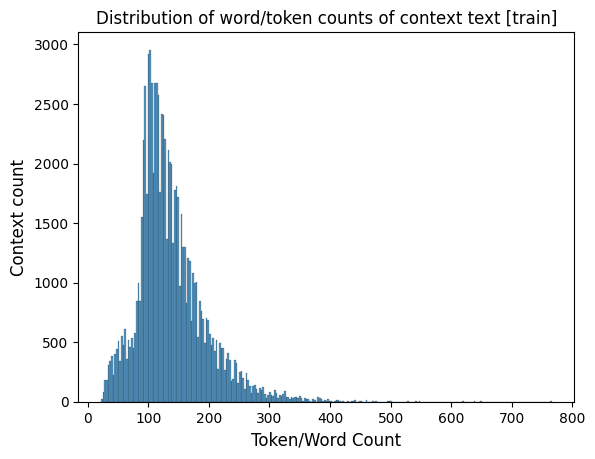

In [ ]:
# Plot histogram to visually analyze distribution
sns.histplot(data=context_train_tok_dist).set(title='Distribution of word/token counts of context text [train]')
plt.xlabel( "Token/Word Count" , size = 12 )
plt.ylabel( "Context count" , size = 12 )
plt.show()

In [ ]:
# get descriptive statistics of context text token lengths
print("[Training] Mean context token length: {}".format(round(np.mean(context_train_tok_dist))))
print("[Training] Min content token length: {}".format(min(context_train_tok_dist)))
print("[Training] Max content token length: {}".format(max(context_train_tok_dist)))

[Training] Mean context token length: 138
[Training] Min content token length: 22
[Training] Max content token length: 766


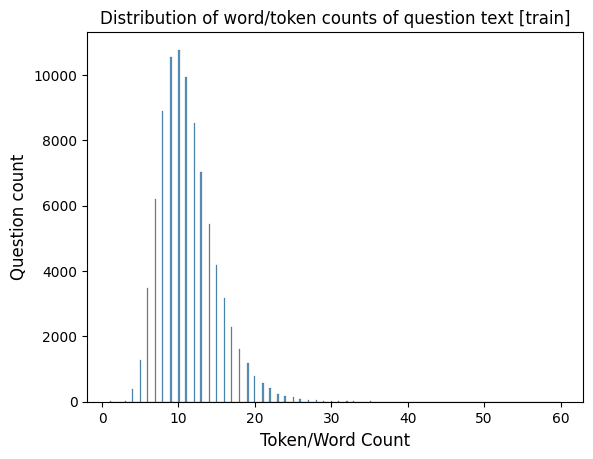

In [ ]:
# Plot histogram to visually analyze distribution
sns.histplot(data=question_train_tok_dist).set(title='Distribution of word/token counts of question text [train]')
plt.xlabel( "Token/Word Count", size = 12 )
plt.ylabel( "Question count", size = 12 )
plt.show()

In [ ]:
# get descriptive statistics of question text token lengths
print("[Training] Mean question token length: {}".format(round(np.mean(question_train_tok_dist))))
print("[Training] Min question token length: {}".format(min(question_train_tok_dist)))
print("[Training] Max question token length: {}".format(max(question_train_tok_dist)))

[Training] Mean question token length: 11
[Training] Min question token length: 1
[Training] Max question token length: 60


## Feature Extraction
-  Tokenize the context and question text using HF tokenizer
-  Use pre-trained BERT model from HF "distilbert-base-cased" (https://huggingface.co/distilbertbert-base-cased).  This model is suitable for Q&A tasks.

In [8]:
# Initiatlize tokenizer from HF transformer lib
from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-cased"
tokenizer1 = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
# test pre-tokenizer on sample
tokenizer1.backend_tokenizer.pre_tokenizer.pre_tokenize_str(questions_train[23])

[('which', (0, 5)),
 ('organization', (6, 18)),
 ('declared', (19, 27)),
 ('the', (28, 31)),
 ('first', (32, 37)),
 ('year', (38, 42)),
 ('of', (43, 45)),
 ('studies', (46, 53)),
 ('program', (54, 61)),
 ('at', (62, 64)),
 ('notre', (65, 70)),
 ('dame', (71, 75)),
 ('"', (76, 77)),
 ('outstanding', (77, 88)),
 ('?', (88, 89)),
 ('"', (89, 90))]

In [ ]:
# test HF tokenizer on a sample from train dataset
inputs = tokenizer1(questions_train[23], contexts_train[23])
tokenizer1.decode(inputs["input_ids"])

'[CLS] which organization declared the first year of studies program at notre dame " outstanding? " [SEP] all of notre dame\'s undergraduate students are a part of one of the five undergraduate colleges at the school or are in the first year of studies program. the first year of studies program was established in 1962 to guide incoming freshmen in their first year at the school before they have declared a major. each student is given an academic advisor from the program who helps them to choose classes that give them exposure to any major in which they are interested. the program also includes a learning resource center which provides time management, collaborative learning, and subject tutoring. this program has been recognized previously, by u. s. news & world report, as outstanding. [SEP]'

### Need to handle some pre-processing along with tokenization:
- Our max input token length for the model pipeline is 384 tokens - so we need to truncate samples that are longer than this.  
    - Only truncate the context - not the question ("only_second)
    - Truncated samples will create multiple new samples, each with different but overlapping section of the context (but same question)
    - Stride will provide overlap/moving window between the context text in the multiple samples (stride defines # of overlap tokens)
    
- Our label for the model (and ultimately what the model will predict) will be the start_pos and end_pos within in the context where the answer is found
    - Our dataset provides start_pos plus the text, making it possible to derive end_pos
    - However, we need to map these from overflow token positions


In [9]:
# initialize new tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [10]:
# helper functions for feature extraction
max_tok_len = 384
stride_len = 128

# tokenize inputs.  since we may have overflow, we need to post-process to create our label set with start/end tokens
def train_tokenize_process(questions, contexts, answers):

    # process all training contexts + questions through tokenizer
    inputs_train = tokenizer(
        questions,
        contexts,
        max_length=max_tok_len,
        truncation="only_second",
        stride=stride_len,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # get offset mapping and overflow mappings
    offset_mapping = inputs_train.pop("offset_mapping")
    sample_map = inputs_train.pop("overflow_to_sample_mapping")

    # build the corresponding label sets for our overflow
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):

        # setup sample idx, answer and seq ids
        qa_sample_idx = sample_map[i]
        answer = answers[qa_sample_idx]
        answer_start_idx = answer['answer_start']
        answer_end_idx = answer_start_idx + len(answer['text'])
        seq_ids = inputs_train.sequence_ids(i)

        # need to traverse to the context so we can get start and end pos
        context_start, context_end = traverse_sequence_ids(seq_ids)

        # context_start gives us the start token of the context, and context_end gives us the end token idx of the context
        # use this to index into offsets to get the start char and end char
        if offset[context_start][0] > answer_start_idx or offset[context_end][1] < answer_end_idx:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= answer_start_idx:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= answer_end_idx:
                idx -= 1
            end_positions.append(idx + 1)

    inputs_train["start_positions"] = start_positions
    inputs_train["end_positions"] = end_positions

    return inputs_train


# tokenize inputs - don't need to worry about mapping labels
def test_tokenize_process(questions, contexts, id_map):

    # process all training contexts + questions through tokenizer
    inputs_test = tokenizer(
        questions,
        contexts,
        max_length=max_tok_len,
        truncation="only_second",
        stride=stride_len,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    example_ids = []
    sample_map = inputs_test.pop("overflow_to_sample_mapping")

    for i in range(len(inputs_test["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(id_map[sample_idx])

        sequence_ids = inputs_test.sequence_ids(i)
        offset = inputs_test["offset_mapping"][i]
        inputs_test["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs_test["example_id"] = example_ids

    return inputs_test


# helper function to extract context start and end from sequence ids
# the sequence IDs encode the tokens so we know where question is and where context is (and delimiter).  ie: None, 0, 0, 0, None, 1, 1, 1, 1 = <delimiter><question tokens (0)><delimiter><context tokens=1>
def traverse_sequence_ids(sequence_ids):
    pos = 0

    # first, traverse until we hit the first "1", the start of the context
    while(sequence_ids[pos] != 1):
        pos += 1
    start_pos = pos

    # next, traverse until we hit a non "1", the end of the context
    while(sequence_ids[pos] == 1):
        pos += 1
    end_pos = pos - 1

    return start_pos, end_pos

#### Run some tests on a few samples to make sure mappings are working as expected in truncation case

In [ ]:
# test - find some samples that need truncation
max(context_train_tok_dist)
i = 0
for x in context_train_tok_dist:
    if(x > 384):
        print(i)
        if (i > 10):
          break
    i = i + 1

447


In [ ]:
# test and inspect truncation is working
st = 446
in_train_exp = train_tokenize_process(questions_train[st:st+5], contexts_train[st:st+5], answers_train[st:st+5])

print(in_train_exp["start_positions"])
print(in_train_exp["end_positions"])

tokenizer.decode(in_train_exp["input_ids"][2])


[238, 24, 0, 94, 0, 253, 0, 0, 165]
[240, 26, 0, 99, 0, 253, 0, 0, 168]


'[CLS] beyonce got married in 2008 to whom? [SEP] ", and singles " diva ", " ego ", " broken - hearted girl " and " video phone ". the music video for " single ladies " has been parodied and imitated around the world, spawning the " first major dance craze " of the internet age according to the toronto star. the video has won several awards, including best video at the 2009 mtv europe music awards, the 2009 scottish mobo awards, and the 2009 bet awards. at the 2009 mtv video music awards, the video was nominated for nine awards, ultimately winning three including video of the year. its failure to win the best female video category, which went to american country pop singer taylor swift\'s " you belong with me ", led to kanye west interrupting the ceremony and beyoncé improvising a re - presentation of swift\'s award during her own acceptance speech. in march 2009, beyoncé embarked on the i am... world tour, her second headlining worldwide concert tour, consisting of 108 shows, grossing

### Run training data and test data through preprocessor

In [ ]:
# run the full dataset through the tokenizer
train_input = train_tokenize_process(questions_train, contexts_train, answers_train)

In [ ]:
# take a peak at some samples
rn = random.randint(1, 10000)
print(train_input["start_positions"][rn:rn+20])
print(train_input["end_positions"][rn:rn+20])

[71, 103, 73, 100, 131, 28, 43, 69, 132, 101, 58, 23, 41, 54, 73, 77, 18, 34, 49, 69]
[74, 114, 74, 103, 134, 31, 48, 70, 136, 105, 60, 26, 43, 56, 75, 79, 21, 36, 51, 71]


In [ ]:
# run test data through pre-processing
test_input = test_tokenize_process(questions_test, contexts_test)

In [11]:
from datasets import Dataset

In [ ]:
# load our datasets into HuggingFace Datasets
train_dataset = Dataset.from_dict(train_input)

# Fine-Tune Pre-trained BERT Model

- Start with simple BERT model: "distilbert-base-cased" (https://huggingface.co/distilbert-base-cased)
- Note: need to pip install ipywidgets to support notebook_login

In [13]:
from transformers import TFAutoModelForQuestionAnswering
from huggingface_hub import notebook_login
from transformers import DefaultDataCollator
from transformers import create_optimizer
from transformers.keras_callbacks import PushToHubCallback

In [15]:
# login to HF Hub
notebook_login()

In [ ]:
# get the pre-trained model
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it

In [21]:
data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
# setup train and test datasets for TensorFlow
tf_train_dataset = model.prepare_tf_dataset(
    train_dataset,
    collate_fn=data_collator,
    shuffle=True,
    batch_size=16,
)

In [ ]:
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
num_train_epochs = 2
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [ ]:
callback = PushToHubCallback(output_dir="distilbert-finetuned-t3-qa", tokenizer=tokenizer)

# train the model
model.fit(tf_train_dataset, callbacks=[callback], epochs=num_train_epochs, verbose=1)

Cloning https://huggingface.co/t4ai/distilbert-finetuned-t3-qa into local empty directory.


Epoch 1/2
   6/5585 [..............................] - ETA: 19:36 - loss: 5.8925

5585/5585 [==============================] - 1209s 215ms/step - loss: 1.5465
Epoch 2/2
5585/5585 [==============================] - 1207s 216ms/step - loss: 0.9890


# Evaluate Model Performance on Test Data

- Evaluation routine and metrics


In [16]:
# get the fine tuned model
model = TFAutoModelForQuestionAnswering.from_pretrained("t4ai/distilbert-finetuned-t3-qa", use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


All model checkpoint layers were used when initializing TFDistilBertForQuestionAnswering.

All the layers of TFDistilBertForQuestionAnswering were initialized from the model checkpoint at t4ai/distilbert-finetuned-t3-qa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


In [18]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.6 MB/s eta 0:00:00


In [42]:
from tqdm.auto import tqdm
import collections
import evaluate
n_best = 20
max_answer_length = 50

metric = evaluate.load("squad")

def compute_metrics(start_logits, end_logits, features, ref_answers, contexts, id_map):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
      example_to_features[feature['example_id']].append(idx)


    predicted_answers = []
    for idx, context in enumerate(contexts):
        example_id = id_map[idx]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    # post process answers for metric format
    formatted_answers = []
    for idx, ans in enumerate(ref_answers):
        formatted_answers.append({'answers': {'answer_start': [ans['answer_start']], 'text': [str.lower(ans['text'])]}, 'id': id_map[idx]})


    return metric.compute(predictions=predicted_answers, references=formatted_answers)


### Test first with a small validation dataset

In [ ]:
# create dataset from test tokens
#test_dataset = Dataset.from_dict(test_input)
val_questions = questions_test[0:20]
val_answers = answers_test[0:20]
val_contexts = contexts_test[0:20]
val_ids = id_map_test[0:20]
val_inputs = test_tokenize_process(val_questions, val_contexts, val_ids)
val_dataset = Dataset.from_dict(val_inputs)
tf_val_dataset = model.prepare_tf_dataset(
    val_dataset,
    collate_fn=data_collator,
    shuffle=False,
    batch_size=16,
)

In [ ]:
# run test dataset through model
val_predictions = model.predict(tf_val_dataset)

2/2 [==============================] - 10s 2s/step


In [ ]:
# extract the logits from the model predictions
start_logits = val_predictions.start_logits
end_logits = val_predictions.end_logits

In [ ]:
#theoretical, predicted =
compute_metrics(start_logits, end_logits, val_dataset, val_answers, val_contexts, val_ids)

### Run with full test dataset

In [22]:
# create dataset from test tokens - leave out data used in val to avoid data leakage
questions_test_sub = questions_test[20:]
answers_test_sub = answers_test[20:]
contexts_test_sub = contexts_test[20:]
test_ids = id_map_test[20:]
test_inputs = test_tokenize_process(questions_test_sub, contexts_test_sub, test_ids)
test_dataset = Dataset.from_dict(test_inputs)
tf_test_dataset = model.prepare_tf_dataset(
    test_dataset,
    collate_fn=data_collator,
    shuffle=False,
    batch_size=16,
)

In [39]:
print("Length of Questions: {}".format(len(questions_test_sub)))
print("Length of Answers: {}".format(len(questions_test_sub)))
print("Length of Contexts: {}".format(len(questions_test_sub)))
print("Length of ID Maps: {}".format(len(questions_test_sub)))

tdi = 0
ft = 0
for idx, feature in enumerate(test_dataset):
  tdi = idx
  if(idx>1):
    ft = feature
    break

print("Length of Dataset: {}".format(tdi))

Length of Questions: 34706
Length of Answers: 34706
Length of Contexts: 34706
Length of ID Maps: 34706
Length of Dataset: 35780


In [41]:
print(ft)

{'input_ids': [101, 1184, 1110, 1103, 17336, 1215, 2049, 2587, 4463, 1106, 1141, 4032, 1207, 19740, 136, 102, 1103, 10074, 118, 2049, 1144, 170, 12676, 14132, 117, 1750, 3337, 1215, 1190, 1103, 1207, 1633, 131, 1103, 180, 24755, 12139, 118, 2049, 113, 4023, 2087, 114, 113, 2121, 180, 24755, 5674, 3276, 114, 117, 1110, 1103, 2049, 4252, 7340, 1174, 1118, 2530, 9926, 1113, 1141, 180, 24755, 12139, 1104, 3367, 119, 1103, 180, 24755, 12139, 118, 2049, 4501, 1106, 1126, 7551, 117, 1133, 6034, 1215, 2587, 1104, 3367, 131, 1103, 12676, 188, 16693, 113, 2121, 15761, 1137, 177, 7777, 114, 1110, 1115, 3367, 1115, 26872, 1116, 1120, 122, 182, 218, 188, 25532, 1477, 1165, 13927, 1106, 170, 2049, 1104, 122, 4023, 2087, 119, 1103, 180, 24755, 12139, 118, 2049, 1110, 1136, 170, 1226, 1104, 1103, 2030, 27466, 1449, 117, 1105, 1110, 2412, 1260, 1643, 1874, 11603, 132, 1649, 1122, 1253, 5302, 1329, 1111, 1199, 4998, 1112, 14819, 2163, 2841, 117, 8319, 7113, 117, 11639, 2910, 6646, 117, 18756, 192, 18129

In [23]:
# run test dataset through model
test_predictions = model.predict(tf_test_dataset)

2237/2237 [==============================] - 3962s 2s/step


In [25]:
# extract the logits from the model predictions
start_logits_test = test_predictions.start_logits
end_logits_test = test_predictions.end_logits

In [43]:
# calculate the performance metrics
compute_metrics(start_logits_test, end_logits_test, test_dataset, answers_test_sub, contexts_test_sub, test_ids)

{'exact_match': 60.29504984728865, 'f1': 74.89556663944832}

# Create Model Pipeline and Run Some Samples



In [ ]:
from transformers import pipeline

# Setup chatbot pipeline
chatbot_qa = pipeline("question-answering", model="t4ai/distilbert-finetuned-t3-qa", use_auth_token=True)

Some layers from the model checkpoint at t4ai/distilbert-finetuned-t3-qa were not used when initializing TFDistilBertForQuestionAnswering: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at t4ai/distilbert-finetuned-t3-qa and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
context = """
The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric slug (sometimes mug or hyl) is that mass that accelerates at 1 m\u00b7s\u22122 when subjected to a force of 1 kgf. The kilogram-force is not a part of the modern SI system, and is generally deprecated; however it still sees use for some purposes as expressing aircraft weight, jet thrust, bicycle spoke tension, torque wrench settings and engine output torque. Other arcane units of force include the sth\u00e8ne, which is equivalent to 1000 N, and the kip, which is equivalent to 1000 lbf.
"""
question = "What is the metric term less used than the Newton?"
chatbot_qa(question=question, context=context)

{'score': 0.09548027813434601,
 'start': 83,
 'end': 97,
 'answer': 'kilogram-force'}

In [ ]:
question = "What is the kilogram-force sometimes reffered to as?"
chatbot_qa(question=question, context=context)

{'score': 0.39763882756233215, 'start': 115, 'end': 123, 'answer': 'kilopond'}